In [1]:
import sys
sys.path.append("..")

import matplotlib.pyplot as plt
import seaborn as sns

from chemgnn.data import load_csv, split_train_test
from chemgnn.datasets.tabular import build_rf_dataset
from chemgnn.models.rf import build_rf
from chemgnn.train.rf_train import (
    cross_validate_rf,
    grid_search_rf,
    train_and_evaluate_rf
)

In [2]:
# 1. raw CSV load
df = load_csv("data_HoC_cyclic_augmented.csv")

# 2. descriptor 계산 + feature/target 분리 (⭐ 핵심 ⭐)
X, y = build_rf_dataset(
    df,
    smiles_col="SMILES",
    target_col="HoC",
)

# 3. split
X_train, X_test, y_train, y_test = split_train_test(
    X, y, test_size=0.2, random_state=41
)

In [3]:
rf = build_rf()
cv_scores = cross_validate_rf(rf, X_train, y_train)
print("CV R2:", cv_scores)

CV R2: [0.89850118 0.860836   0.94388726 0.30367721 0.7825891 ]


In [4]:
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
}

gs = grid_search_rf(build_rf(), param_grid, X_train, y_train)
print("Best params:", gs.best_params_)

Best params: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [5]:
best_rf = build_rf(**gs.best_params_)

results = train_and_evaluate_rf(
    best_rf, X_train, y_train, X_test, y_test
)

print(results)

{'r2_train': 0.9931538270603908, 'r2_test': 0.9645832857961546, 'mae_train': 0.2765067772150077, 'mae_test': 0.9568097738816749, 'y_train_pred': array([-10.56044664,  -6.4351547 ,  -5.06193346,  -4.8448046 ,
        -9.13826179, -12.21807808, -11.97453269, -10.26558518,
       -12.00202519,  -6.36387071,  -2.63568733, -11.87637386,
        -6.03739695, -12.50985403,  -9.00330073, -12.42735308,
        -6.20143508,  -9.36355739, -20.349285  ,  -2.89590167,
        -9.58278556,  -5.0501185 , -10.36061102,  -2.287058  ,
        -3.77771272, -18.267162  ,  -6.060897  ,  -7.85361814,
        -4.070748  ,  -3.23083467, -11.47632386,  -4.8003122 ,
        -7.14670266,  -6.34970005,  -5.36143999,  -3.523476  ,
        -5.003668  ,  -6.209155  ,  -5.10021967,  -2.297432  ,
       -15.28904933, -19.348085  , -16.53068567,  -4.06386139]), 'y_test_pred': array([ -5.06780696, -15.16553333, -16.408548  ,  -6.50463154,
       -17.77892067,  -4.99419605,  -2.43586945,  -2.43291545,
       -18.87621867

In [6]:
from chemgnn.evaluate import regression_metrics

train_pred = results["y_train_pred"]
test_pred  = results["y_test_pred"]

metrics_train = regression_metrics(y_train, train_pred)
metrics_test  = regression_metrics(y_test, test_pred)

print(metrics_train)
print(metrics_test)


{'MAE': 0.2765067772150077, 'RMSE': 0.40092408792446577, 'R2': 0.9931538270603908}
{'MAE': 0.9568097738816749, 'RMSE': 1.303056963614901, 'R2': 0.9645832857961546}


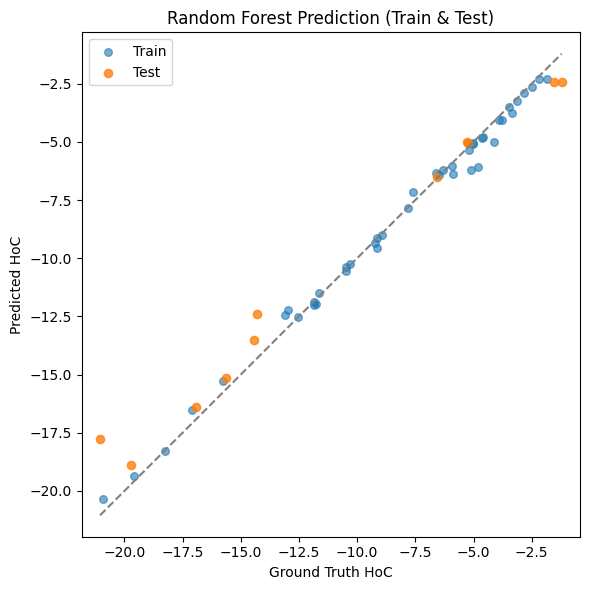

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

# Train
plt.scatter(
    y_train,
    train_pred,
    alpha=0.6,
    s=30,
    label="Train",
)

# Test
plt.scatter(
    y_test,
    test_pred,
    alpha=0.8,
    s=35,
    label="Test",
)

# y = x
min_val = min(y_train.min(), y_test.min())
max_val = max(y_train.max(), y_test.max())

plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    "--",
    color="gray",
)

plt.xlabel("Ground Truth HoC")
plt.ylabel("Predicted HoC")
plt.title("Random Forest Prediction (Train & Test)")
plt.legend()
plt.axis("equal")
plt.tight_layout()
plt.show()
